In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

import os

import numpy as np

import automation, parameters

In [10]:
from imp import reload
reload(automation)

<module 'automation' from '/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/git/hubble-focus/automation/automation.py'>

# Running fitpsf on a single image

In [11]:
image1 = automation.FocusImage('/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03bkq_flt.fits', extension = 1)
image1.find_sources(sigma = 10., fwhm = 4., isolation = 30., roundlo = -0.2, roundhi = 0.2, peak_threshold = 2000.)
image1.find_backgrounds()

(<matplotlib.figure.Figure at 0x11057c240>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ec3ac18>)

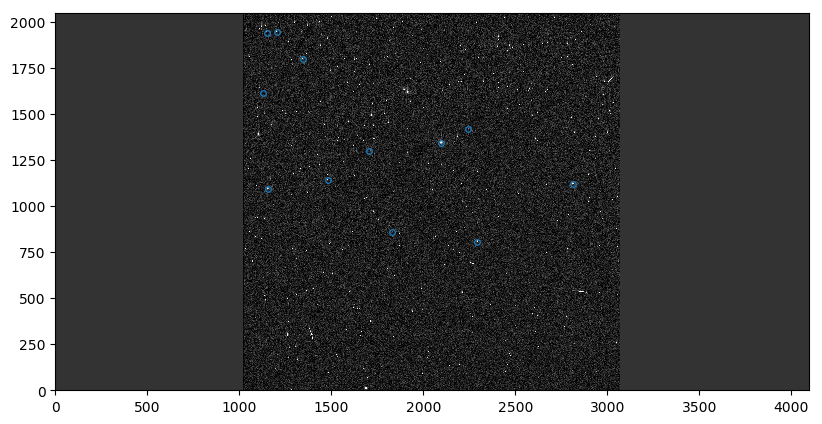

In [12]:
image1.display_image()

In [13]:
results = automation.multifitpsf(image1.filepath, image1.sources, image1.backgrounds,
                       parameters.InputParams('wfc3uvis2'), nprocesses = 3)

INFO:automation:Creating temporary directory process0
INFO:automation:Creating temporary directory process1
INFO:automation:Creating temporary directory process2
INFO:automation:FITS files: ['/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03bkq_flt']
INFO:automation:FITS files: ['/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03bkq_flt']
INFO:automation:FITS files: ['/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03bkq_flt']
INFO:automation:Fitting PSFs for 4 stars.
INFO:automation:Fitting PSFs for 4 stars.
INFO:automation:Fitting PSFs for 4 stars.
INFO:automation:Producing .cos and .dat files...
INFO:automation:Producing .cos and .dat files...
INFO:automation:Producing .cos and .dat files...
INFO:automation:Fitting star [1481.7541606567277,1141.1054913402213] (1/4)
INFO:automation:Fitting star [2293.741709278607,808.0104425161617] (1/4)
INFO:auto

Inspect results:

In [14]:
print(results.dtype.names)

('filename', 'x', 'y', 'focus', 'xcoma', 'ycoma', 'xastig', 'yastig', 'spherical', 'xclover', 'yclover', 'xspherical_astig', 'yspherical_astig', 'xashtray', 'yashtray', 'fifth_spherical', 'background1', 'xtilt1', 'ytilt1', 'blur')


In [15]:
print(results.focus / 0.006)

[ 1.69683333  4.405       0.4524     -0.40513333  4.77316667  0.7264
 -0.71145    -1.48695     2.35316667 -1.48791667  4.77916667  2.06916667]


# Running fitpsf across multiple images

Make the list of images

In [16]:
image_files = ['iddo03biq_flt.fits',
          'iddo03buq_flt.fits',
          'iddo03c0q_flt.fits',
          'iddo03c4q_flt.fits']

imlist = [os.path.join('/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/',im) for im in image_files]

Independently find sources and backgrounds in each of the images

In [17]:
images = []
for im in imlist:
    image = automation.FocusImage(im, extension = 1)
    image.find_sources(sigma = 10., fwhm = 4., isolation = 30., roundlo = -0.2, roundhi = 0.2, peak_threshold = 2000.)
    image.find_backgrounds()
    images.append(image)

Reduce to only those sources that can be found in all images, using the first image as a reference.

In [18]:
# Find indices of matching sources
ref = images[0].sources
others = [im.sources for im in images[1:]]
ref_idx, other_idx = automation.match_many_source_lists(ref, others, return_indices = True)

# Make list of matching sources (ordered by reference)
common_sources = [ref[ref_idx],]
common_sources.extend([o[o_idx] for o, o_idx in zip(others, other_idx)])
# Make corresponding list of matching backgrounds
ref_bg = images[0].backgrounds
others_bg = [im.backgrounds for im in images[1:]]
common_bgs = [ref_bg[ref_idx],]
common_bgs.extend([b[b_idx] for b, b_idx in zip(others_bg, other_idx)])

Run like before, only now we use a .in file for multi-image fitting.

In [19]:
results = automation.multifitpsf(imlist, common_sources, common_bgs,
                                 parameters.InputParams('wfc3uvis2', nfiles = len(imlist)),
                                 nprocesses = 1)

INFO:automation:Creating temporary directory process0
INFO:automation:FITS files: ['/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03biq_flt', '/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03buq_flt', '/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03c0q_flt', '/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03c4q_flt']
INFO:automation:Fitting PSFs for 5 stars.
INFO:automation:Producing .cos and .dat files...
INFO:automation:Fitting star [1594.9779588743204,469.16444669071035] (1/5)
INFO:automation:Running fitpsf...
INFO:automation:Producing .cos and .dat files...
INFO:automation:Fitting star [2857.1614014892734,652.2184722687297] (2/5)
INFO:automation:Running fitpsf...
INFO:automation:Producing .cos and .dat files...
INFO:automation:Fitting star [1253.6977540180942,860.407204877441] (3/5)
INFO:autom

In [20]:
print(results.focus1)

[-0.21831 -1.2353   0.12167  0.19121  0.99014]


In [21]:
print(results.focus2)

[-0.63486   0.24469   0.66635  -0.061566 -1.7991  ]


# Spatial Variations

Here we'll fit the stars in a single image, but we'll add a term with spatial-dependence to demonstrate this capability.

In [22]:
image1 = automation.FocusImage('/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03bkq_flt.fits', extension = 1)
image1.find_sources(sigma = 10., fwhm = 4., isolation = 30., roundlo = -0.2, roundhi = 0.2, peak_threshold = 2000.)
image1.find_backgrounds()

We fix blur to its default value and 

In [25]:
params = parameters.InputParams('wfc3uvis2')
params.blur.fit = 'N'

# 2D 3rd-order coefficients
xastig_coeffs = np.array([  5.29289616e-03,  -2.69395661e-06,   3.66780849e-09,
                            7.49176458e-07,  -6.98760922e-10,  -1.70814344e-12,
                            1.09197541e-10,  -2.00603578e-14,   2.57952221e-16])
yastig_coeffs = np.array([  2.52761982e-02,   3.44806405e-06,  -1.80518610e-09,
                           -5.47959150e-06,  -5.52493754e-09,   1.18408699e-12,
                           -2.70272113e-10,   1.37136699e-12,  -2.74998126e-16])
# Set up a dictionary with a function to evaluate with any arguments
# spatial_funcs['key'] = (func, (arg1, arg2,))
spatial_funcs = {'xastig' : ( automation.polyval2d, (xastig_coeffs,) ),
                 'yastig' : ( automation.polyval2d, (yastig_coeffs,) )}
# Set astigmastism terms to fixed. Value doesn't matter in this case, since it'll be replaced.
params.xastig.fit = 'N'
params.yastig.fit = 'N'

Call multifitpsf with the parameters and spatial-dependence:

In [26]:
results = automation.multifitpsf(image1.filepath, image1.sources, image1.backgrounds,
                      params, spatial_funcs = spatial_funcs, nprocesses = 3)

INFO:automation:Creating temporary directory process0
INFO:automation:Creating temporary directory process1
INFO:automation:Creating temporary directory process2
INFO:automation:FITS files: ['/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03bkq_flt']
INFO:automation:FITS files: ['/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03bkq_flt']
INFO:automation:FITS files: ['/Users/kgorkom/Desktop/Things/TEL/Hubble_Focus/monitoring_data/prop_14866/visit03-apr2017/iddo03bkq_flt']
INFO:automation:Fitting PSFs for 4 stars.
INFO:automation:Fitting PSFs for 4 stars.
INFO:automation:Fitting PSFs for 4 stars.
INFO:automation:Producing .cos and .dat files...
INFO:automation:Producing .cos and .dat files...
INFO:automation:Producing .cos and .dat files...
INFO:automation:Fitting star [2293.741709278607,808.0104425161617] (1/4)
INFO:automation:Fitting star [1130.3011932812865,1613.197728348609] (1/4)
INFO:autom